The following notebook uses an MLP classifier to learn where initial points on the complex plane will converge to under iterations of Newtons method using the polynomial z**3-1. We then compare the results to that obtained by Newtons method.

In [1]:
import sys
from scipy import optimize
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

First we will define our polynomial and its derivative which we wish to learn the roots of.

In [2]:
def f(z):
    return (z**3 - 1)

def deriv(z):
    return 3*(z**2)

Next, we will define two sets of initial points on the complex plane, one consisting of randomly chosen points to learn/test from and another on a grid to validate what we have learned. We also print the shapes of these two sets. 

In [3]:
I=np.random.uniform(-1,1,(5000,2))

x=np.linspace(-1,1,200)
y=np.linspace(-1,1,200)             
T=np.array(np.meshgrid(x,y)).T.reshape(-1,2)

print(I.shape)
print(T.shape)

(5000, 2)
(40000, 2)


Here is a scatter plot of these two sets. 

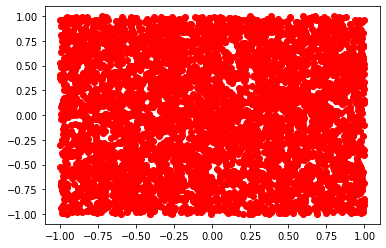

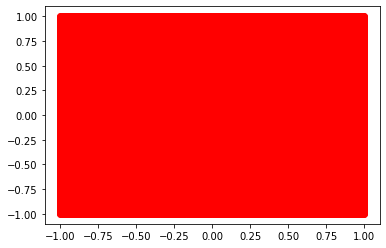

In [4]:
plt.scatter(I[:,0],I[:,1], c='red')
plt.figure()
plt.scatter(T[:,0],T[:,1], c='red')

Next, we will use optimize.newton from the scipy package to obtain the roots of the polynomial via Newtons method using the points from our sets as the inital starting point. We will do this for each of the two sets defined above and store the roots in 'output' for the random set and 'output2' for the grid set. 

In [5]:
root = np.array([])
root2 = np.array([])

for i in range(len(I)):
    root = np.append(root, optimize.newton(f, x0=complex(I[i,0],I[i,1]), fprime=deriv, tol=.001))

for i in range(len(T)):
    root2 = np.append(root2, optimize.newton(f, x0=complex(T[i,0],T[i,1]), fprime=deriv, tol=.001))
    
output = np.array([root[:].real,root[:].imag]).T
output2 = np.array([root2[:].real,root2[:].imag]).T

Next we make scatter plots of the three roots obtained from each set.

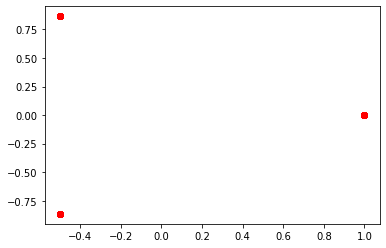

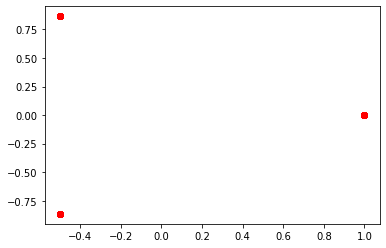

In [6]:
plt.scatter(output[:,0],output[:,1], c='red')
plt.figure()
plt.scatter(output2[:,0],output2[:,1], c='red')

Now we will label each of the three roots by defining a ball of radius r around what we know to be the analytical zeros. If a root lies within the ball of radius r centered at the point (1,0) it will be labeled as a '0'. If a root lies within the ball of radius r centered at the point (-0.5,sqrt(3)/2) it will be labeled as a '1' If a root lies within the ball of radius r centered at the point (-0.5,-sqrt(3)/2) it will be labeled as a '-1' and if a root does not lie within these three regions (perhaps because we did not iterate Newtons method long enough) it will be labeled as a '2'.

In [7]:
r = .25

O = np.array([])
for i in range(len(output)):
    if ((output[i,0] - 1)**2 + (output[i,1] - 0)**2 < r):
        O = np.append(O, 0)
    elif (output[i,0] + 0.5)**2 + (output[i,1] - (np.sqrt(3)/2))**2 < r:
        O = np.append(O, 1)
    elif ((output[i,0] + 0.5)**2 + (output[i,1] + (np.sqrt(3)/2))**2 < r):
        O = np.append(O, -1)
    else:
        O = np.append(O, 2)

TO = np.array([])
for i in range(len(output2)):
    if ((output2[i,0] - 1)**2 + (output2[i,1] - 0)**2 < r):
        TO = np.append(TO, 0)
    elif (output2[i,0] + 0.5)**2 + (output2[i,1] - (np.sqrt(3)/2))**2 < r:
        TO = np.append(TO, 1)
    elif ((output2[i,0] + 0.5)**2 + (output2[i,1] + (np.sqrt(3)/2))**2 < r):
        TO = np.append(TO, -1)
    else:
        TO = np.append(TO, 2)

Next, just for fun, we will prepare an initial data set (a pandas data frame) to visualize. The first two columns will consist of the coordinates of the randomly chosen points, and the last column will be the label we have assigned that root. 

In [8]:
data_fname = np.hstack([I, np.expand_dims(O, axis=1)])
data = pd.DataFrame(data_fname)

Here is what that data set looks like. 

In [9]:
data

,0,1,2
0,-0.851103,0.635279,1.0
1,-0.122840,0.729153,1.0
2,-0.118746,0.352844,1.0
3,0.370004,0.476345,-1.0
4,0.876131,0.995388,0.0
...,...,...,...
4995,-0.904581,-0.617889,-1.0
4996,0.435227,0.800464,-1.0
4997,0.389723,0.908954,0.0
4998,-0.973925,-0.522856,-1.0


Now we are ready to split our data set into a training set and a test set. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(I, O, test_size=0.5)

We are now in a position to define the MLP classifier and use it to learn the roots. We print out the accuracy on both the test and validation (grid) sets as well as the confusion matrix for both. 

In [11]:
#MLP Classifier

model = MLPClassifier(hidden_layer_sizes=(100,100,100,100), activation='relu', learning_rate_init=0.001, max_iter=1000)

model.fit(X_train, y_train);

score = model.score(X_test, y_test)
print("Score on test set:", score)
print(confusion_matrix(y_test, model.predict(X_test)))

score = model.score(T, TO)
print("Score on validation (grid) set:", score)
print(confusion_matrix(TO, model.predict(T)))

Score on test set: 0.9296
[[786  19  32]
 [ 38 793  25]
 [ 44  18 745]]
Score on validation (grid) set: 0.924675
[[12468   263   580]
 [  692 12177   509]
 [  702   267 12342]]


We can now make color coded scatter plots of the test set using the results obtained from both Newtons method and the MLP classifier. 

<Figure size 432x288 with 0 Axes>

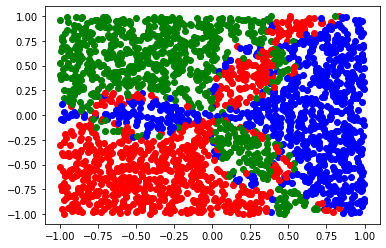

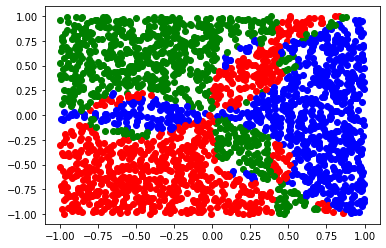

<Figure size 432x288 with 0 Axes>

In [12]:
# Newton method
for i in range(len(y_test)):
    if y_test[i]==-1:
        plt.scatter(X_test[i,0],X_test[i,1], c='red')
    if y_test[i]==1:
        plt.scatter(X_test[i,0],X_test[i,1], c='green')
    if y_test[i]==0:
        plt.scatter(X_test[i,0],X_test[i,1], c='blue')
    if y_test[i]==2:
        plt.scatter(X_test[i,0],X_test[i,1], c='black')
plt.figure()

# MLP method
for i in range(len(model.predict_proba(X_test)[:,0])):
    if model.predict(X_test)[i]==-1:
        plt.scatter(X_test[i,0],X_test[i,1], c='red')
    if model.predict(X_test)[i]==1:
        plt.scatter(X_test[i,0],X_test[i,1], c='green')
    if model.predict(X_test)[i]==0:
        plt.scatter(X_test[i,0],X_test[i,1], c='blue')
    if model.predict(X_test)[i]==2:
        plt.scatter(X_test[i,0],X_test[i,1], c='black')
plt.figure()

We will now do the same for the grid/validation set. 

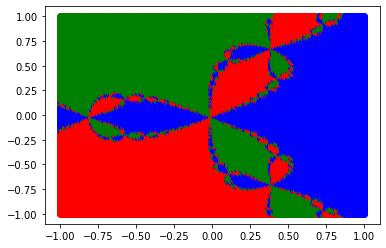

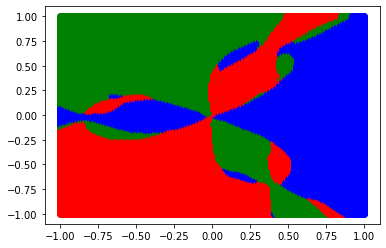

In [13]:
# Newtons method
for i in range(len(TO)):
    if TO[i]==-1:
        plt.scatter(T[i,0],T[i,1], c='red')
    if TO[i]==1:
        plt.scatter(T[i,0],T[i,1], c='green')    
    if TO[i]==0:
        plt.scatter(T[i,0],T[i,1], c='blue')
    if TO[i]==2:
        plt.scatter(T[i,0],T[i,1], c='black')
plt.figure()

# MLP method
for i in range(len(model.predict_proba(T)[:,0])):
    if model.predict(T)[i]==-1:
        plt.scatter(T[i,0],T[i,1], c='red')
    if model.predict(T)[i]==1:
        plt.scatter(T[i,0],T[i,1], c='green')
    if model.predict(T)[i]==0:
        plt.scatter(T[i,0],T[i,1], c='blue')
    if model.predict(T)[i]==2:
        plt.scatter(T[i,0],T[i,1], c='black')       

At this point we are essentially done, however, it would be interesting to see where the MLP classifier was less confident in its predictions. We can do this by using the model.predict_proba command. We define the variable 'p' and only plot the points which achieved a prediction probability greater than p.

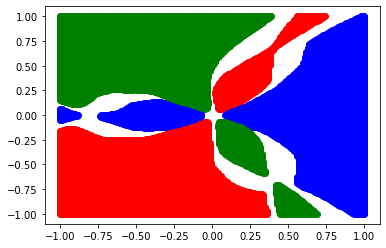

In [14]:
p=0.9
c0=model.predict_proba(T)[:,0]
c1=model.predict_proba(T)[:,1]
c2=model.predict_proba(T)[:,2]

I=np.argwhere(c0>p)
J=np.argwhere(c1>p)
K=np.argwhere(c2>p)

plt.figure()
plt.scatter(T[I,0],T[I,1], c='red')
plt.scatter(T[J,0],T[J,1], c='blue')
plt.scatter(T[K,0],T[K,1], c='green')

if len(model.predict_proba(T)[0])>3:
    c3=model.predict_proba(T)[:,3]
    L=np.argwhere(c3>p)
    plt.scatter(T[L,0],T[L,1], c='black')

It is interesting to note that the points that the MLP classifier were less confident in classifying were the ones near the boundaries. 

In conclusion, the MLPclassifier did quite well, obtaining over 90% accuracy in predicting which initial points would convert to which roots after performing Newtons method.